In [1]:
import tensorflow as tf
import numpy as np

In [2]:
x = tf.constant([[1., 2., 3.],
                 [4., 5., 6.],
                 [7., 8., 9.]])
print(x)
x = tf.reshape(x, [1, 3, 3, 1])
x

tf.Tensor(
[[1. 2. 3.]
 [4. 5. 6.]
 [7. 8. 9.]], shape=(3, 3), dtype=float32)


<tf.Tensor: shape=(1, 3, 3, 1), dtype=float32, numpy=
array([[[[1.],
         [2.],
         [3.]],

        [[4.],
         [5.],
         [6.]],

        [[7.],
         [8.],
         [9.]]]], dtype=float32)>

In [ ]:
x = tf.zeros([5,5,1,20])
x = tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2))
print(x.eval())

Error: Session cannot generate requests

In [2]:
x = [-.5,.5,.5,.5,.5]
y = tf.nn.softmax(x)
print(y)
y = tf.nn.softmax(y)
print(y)

tf.Tensor([0.08422382 0.22894405 0.22894405 0.22894405 0.22894405], shape=(5,), dtype=float32)
tf.Tensor([0.17784528 0.20553868 0.20553868 0.20553868 0.20553868], shape=(5,), dtype=float32)


In [3]:
print(tf.reduce_mean(y))

tf.Tensor(0.2, shape=(), dtype=float32)


In [33]:
# This function to generate evidence is used for the first example
def relu_evidence(logits):
    return tf.nn.relu(logits)

# This one usually works better and used for the second and third examples
# For general settings and different datasets, you may try this one first
def exp_evidence(logits): 
    return tf.exp(tf.clip_by_value(logits,-10,10))

# This one is another alternative and 
# usually behaves better than the relu_evidence 
def softplus_evidence(logits):
    return tf.nn.softplus(logits)
K=10
def KL(alpha):
    # print("K:",K)
    beta=tf.constant(np.ones((1,K)),dtype=tf.float32)
    S_alpha = tf.cast(tf.reduce_sum(alpha,axis=1,keepdims=True),tf.float32)
    
    # print("lgama",tf.compat.v1.lgamma(S_alpha) )
    S_beta = tf.reduce_sum(beta,axis=1,keepdims=True)
    lnB = tf.compat.v1.lgamma(S_alpha) - tf.reduce_sum(tf.compat.v1.lgamma(alpha),axis=1,keepdims=True)
    lnB_uni = tf.reduce_sum(tf.compat.v1.lgamma(beta),axis=1,keepdims=True) - tf.compat.v1.lgamma(S_beta)
    
    dg0 = tf.compat.v1.digamma(S_alpha)
    dg1 = tf.compat.v1.digamma(alpha)
    
    kl = tf.reduce_sum((alpha - beta)*(dg1-dg0),axis=1,keepdims=True) + lnB + lnB_uni
    # print("kl", kl)
    return kl
def mse_loss_global(labels, outputs): 
#         labels = tf.one_hot(tf.cast(labels, tf.int32), 10)
# #         print("onehot",labels)
#         labels = tf.cast(labels, dtype=tf.float32)
#         try:
#             labels= tf.squeeze(labels,[1])
#         except:
#                 print("loss labels can't be squeezed")
        print("global Loss")
        evidence = softplus_evidence(outputs)
        # print("evid_relu",evidence)
        alpha = evidence + 1
        alpha = tf.cast(alpha, tf.float32)
        # print("alpha",alpha)
        S = tf.reduce_sum(alpha, axis=1, keepdims=True) 
        E = alpha - 1
        m = alpha / S
#         print("m",m)
#         print("global", labels)
        A = tf.reduce_sum((labels-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 

        annealing_coef = tf.minimum(1.0,tf.cast(1,tf.float32))
#         annealing_coef = 1
        print(E*(1-labels))
        alp = E*(1-labels) +1
        print("alp", alp)
        C =  annealing_coef * KL(alp)
#         print(alpha)
        # C = tf.keras.losses.kld(labels, alp)
        print("C", C)
        # return (A + B) + C
        return C


In [44]:
def calcEntropy_Tensors(y_hat):
        rank = tf.rank(y_hat)
        print(rank)
        def calc_E(y_hat):
            results = tf.clip_by_value((tf.math.log(y_hat)/tf.math.log(tf.constant(2, dtype=y_hat.dtype))), -1e12, 1e12)
            return tf.reduce_sum(y_hat * results)
        sumEntropies = (tf.map_fn(calc_E,tf.cast(y_hat,'float')))
        print(sumEntropies)
        if rank == 1:
            sumEntropies = tf.reduce_sum(sumEntropies)
        return -sumEntropies

def calcEntropy_Tensors2(y_hat):
    #entropy is the sum of y * log(y) for all possible labels.
    #doesn't deal with cases of log(0)
    val = y_hat * tf.math.log(y_hat)/tf.math.log(tf.constant(2, dtype=y_hat.dtype))
    print(val)
    print(tf.boolean_mask(val,tf.math.is_finite(val)))
    sumEntropies =  tf.reduce_mean(tf.boolean_mask(val,tf.math.is_finite(val)),axis=1)
    return -sumEntropies


labels =  np.array([[0., 0., 0., 0., 0., 0., 0. ,0. ,1., 0.]])

outputs = np.array([[ -5.2393117,  -5.6626554, -0.653389 , -0.531464 , -19.877066 ,
        -16.617638 , -17.549894 , -21.920752 ,  10.4453455,  -8.612539 ]])

outputs = tf.Variable([[ .5,23,1.5],[1,1.5,1]])

print(calcEntropy_Tensors(outputs))


tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor([104.419365    0.8774438], shape=(2,), dtype=float32)
tf.Tensor([-104.419365    -0.8774438], shape=(2,), dtype=float32)


In [143]:
outputs =tf.Variable([[ -5.2393117,  -5.6626554, -0.653389 , -0.531464 , -19.877066 ,
            -16.617638 , -17.549894 , -21.920752 ,  -5.4453455,  -8.612539 ],
            [ -5.2393117,  -5.6626554, -0.653389 , -0.531464 , -19.877066 ,
            -16.617638 , -17.549894 , -21.920752 ,  -5.4453455,  -8.612539 ],[ -5.2393117,  -5.6626554, -0.653389 , -0.531464 , -19.877066 ,
            -16.617638 , -17.549894 , -21.920752 ,  -5.4453455,  -8.612539 ]])
def evidence_spike(outputs):
    num_classes = 10
    batch_size = outputs.shape[0]
    print(batch_size)
    for i,output in enumerate(outputs):
        outputs[i] = output+ abs(tf.reduce_min(outputs,1)[i])
    # print(outputs)
    # outputs = outputs + abs(tf.reduce_min(outputs,1))
    # print(outputs)
    norms = tf.keras.utils.normalize(outputs)
    # print(norms)
    predMax_idx = tf.argmax(outputs,1)
    predMax = tf.keras.utils.to_categorical(predMax_idx,num_classes)

    # print("predicted output:", tf.reduce_sum(np.multiply(norms, predMax)))
    results_correct = tf.reduce_sum(np.multiply(norms, predMax))/batch_size
    # print(results_correct)
    coef = 1/ results_correct
    # print("coef",coef)
    results_incorrect = tf.reduce_mean(norms* abs(predMax-1))/batch_size
    # print(results_correct, results_incorrect)
    # print("evidence: ", results_correct *coef - results_incorrect* coef)
    print(results_correct *coef - results_incorrect* coef)
evidence_spike(outputs)

3
tf.Tensor(0.8508471820099855, shape=(), dtype=float64)


In [154]:
# outputs = np.array([-1.,-2.,-9.])
import numpy as np
import tensorflow as tf
labels =  tf.Variable([[0., 0., 0., 0., 0., 0., 0. ,0. ,1., 0.],[0., 0., 0., 0., 0., 0., 0. ,0. ,1., 0.],[0., 0., 0., 0., 0., 0., 0. ,0. ,1., 0.]])
outputs = tf.Variable([[ -5.2393117,  -5.6626554, -0.653389 , -0.531464 , -19.877066 ,
            -16.617638 , -17.549894 , -20.920752 ,  -5.4453455,  -8.612539 ],
            [ -5.2393117,  -5.6626554, -0.653389 , -0.531464 , -19.877066 ,
            -16.617638 , -17.549894 , -21.920752 ,  -5.4453455,  -8.612539 ],[ -5.2393117,  -5.6626554, -0.653389 , -0.531464 , -19.877066 ,
            -16.617638 , -17.549894 , -15.920752 ,  -5.4453455,  -8.612539 ]])
def evidence_spike(outputs):
    num_classes = 10
    batch_size = outputs.shape[0]
    print(batch_size)
    # print(tf.reduce_min(outputs,1))



    mins = abs(tf.reduce_min(outputs,1))
    print(mins)
    mins_a= tf.repeat(mins,10)
    mins_a = tf.reshape(mins_a, outputs.shape)
    # mins_a = tf.zeros([0,num_classes])
    # for i, val in enumerate(mins):
        # mins_a = tf.concat(tf.repeat(val,num_classes),1)



    # print(mins_a)
    # print(abs(mins))
    outputs = outputs + mins_a
    # for i,output in mins:
    #     print("i",i)
    #     print("outputs",output)
    #     outputs[i] = output+ abs(tf.reduce_min(outputs,1)[i])
    # print(outputs)
    # outputs = outputs + abs(tf.reduce_min(outputs,1))
    # print(outputs)
    norms = tf.keras.utils.normalize(outputs)
    print(norms)

    predMax_idx = tf.argmax(outputs,1)
    predMax = tf.keras.utils.to_categorical(predMax_idx,num_classes)

    # print("predicted output:", tf.reduce_sum(np.multiply(norms, predMax)))
    results_correct = tf.reduce_sum(np.multiply(norms, predMax))/batch_size
    print(results_correct)
    coef = 1/ results_correct
    print("coef",coef)
    results_incorrect = tf.reduce_mean(norms* abs(predMax-1))/batch_size
    print(results_correct, results_incorrect)
    print("evidence: ", results_correct *coef - results_incorrect* coef)

evidence_spike(outputs)

# evidence_spike(tf.Variable([[ -5.2393117,  -5.6626554, -0.653389 , -0.231464 , -19.877066 , -16.617638 ,
            #   -17.549894 , -21.920752 ,  -5.4453455,  -8.612539 ]]))



3
tf.Tensor([20.920752 21.920752 19.877066], shape=(3,), dtype=float32)
tf.Tensor(
[[0.37732908 0.36714253 0.4876762  0.49061    0.02511332 0.10354215
  0.08111005 0.         0.37237146 0.29616198]
 [0.3775328  0.36795172 0.48132098 0.48408037 0.04625251 0.12001958
  0.09892084 0.         0.37286988 0.30119023]
 [0.37459245 0.3637587  0.49195004 0.49507022 0.         0.08341151
  0.05955427 0.1012454  0.36931986 0.28826872]], shape=(3, 10), dtype=float32)
tf.Tensor(0.48992023, shape=(), dtype=float32)
coef tf.Tensor(2.0411487, shape=(), dtype=float32)
tf.Tensor(0.48992023, shape=(), dtype=float32) tf.Tensor(0.07120673, shape=(), dtype=float32)
evidence:  tf.Tensor(0.85465646, shape=(), dtype=float32)


In [85]:
x = np.array([[1,2,3]])
y = np.array([[1,0,1]])
print(np.multiply(x,y))

[[1 0 3]]


In [169]:
def KL_evidence(labels, outputs): 
#         labels = tf.one_hot(tf.cast(labels, tf.int32), 10)
# #         print("onehot",labels)
#         labels = tf.cast(labels, dtype=tf.float32)
#         try:
#             labels= tf.squeeze(labels,[1])
#         except:
#                 print("loss labels can't be squeezed")
        print("Kl Evidence")
        evidence = softplus_evidence(outputs)
        print("evidence",evidence)
        print("evidence",tf.reduce_sum(evidence))
        alpha = evidence + 1
        alpha = tf.cast(alpha, tf.float32)
        # print("alpha",alpha)
        S = tf.reduce_sum(alpha, axis=1, keepdims=True) 
        E = alpha - 1
        m = alpha / S
#         print("m",m)
#         print("global", labels)
        A = tf.reduce_sum((labels-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 

        annealing_coef = tf.minimum(1.0,tf.cast(1,tf.float32))
#         annealing_coef = 1
        print("1-labels", (labels * 5))
        print(tf.keras.losses.categorical_crossentropy([1.0],[1.0]))

        alp = E*(1-labels) +1
        print("alp", alp)
        C =  annealing_coef * KL(alp)
#         print(alpha)
        # C = tf.keras.losses.kld(labels, alp)
        print("C", C)
        # return (A + B) + C
        return C

labels =  np.array([[0., 0., 0., 0., 0., 0., 0. ,0. ,1., 0.]])
# outputs = np.array([[-0.867575228, -1.408539593, -0.3238, -4.99858856, -4.85228109,
#                      -6.52761173, -6.87370205, -6.45510149, 0.890240133 ,-2.260957]])

outputs = np.array([[ -5.2393117,  -5.6626554, -0.653389 , -0.531464 , -19.877066 ,
        -16.617638 , -17.549894 , -21.920752 ,  10.4453455,  -8.612539 ]])
outputs = np.array([[0., 0., 0., 0., -10., 0.5, 1. ,-1. ,1, 0.  ]])
print("softmax",tf.nn.softmax(outputs))
print("kl relu", tf.keras.losses.kl_divergence(labels,(labels * softplus_evidence(outputs))))
print("sigmoid cross",tf.keras.losses.categorical_crossentropy(labels,tf.cast(tf.sigmoid(outputs),tf.float32),True))
print("cross",tf.keras.losses.categorical_crossentropy(labels,tf.cast((outputs),tf.float32),True))
print("softmax cross",tf.keras.losses.categorical_crossentropy(labels,tf.cast((tf.nn.softmax(outputs)),tf.float32),True))
print(KL_evidence(labels,outputs))

softmax tf.Tensor(
[[8.03005826e-02 8.03005826e-02 8.03005826e-02 8.03005826e-02
  3.64564081e-06 1.32393279e-01 2.18279615e-01 2.95409335e-02
  2.18279615e-01 8.03005826e-02]], shape=(1, 10), dtype=float64)
kl relu tf.Tensor([0.], shape=(1,), dtype=float64)
sigmoid cross tf.Tensor([2.0765529], shape=(1,), dtype=float32)
cross tf.Tensor([1.5219785], shape=(1,), dtype=float32)
softmax cross tf.Tensor([2.1866343], shape=(1,), dtype=float32)
Kl Evidence
evidence tf.Tensor(
[[6.93147181e-01 6.93147181e-01 6.93147181e-01 6.93147181e-01
  4.53988992e-05 9.74076984e-01 1.31326169e+00 3.13261688e-01
  1.31326169e+00 6.93147181e-01]], shape=(1, 10), dtype=float64)
evidence tf.Tensor(7.379643348433719, shape=(), dtype=float64)
1-labels [[0. 0. 0. 0. 0. 0. 0. 0. 5. 0.]]
tf.Tensor(1.192093e-07, shape=(), dtype=float32)
alp tf.Tensor(
[[1.6931472 1.6931472 1.6931472 1.6931472 1.0000454 1.974077  2.3132617
  1.3132616 1.        1.6931472]], shape=(1, 10), dtype=float32)
C tf.Tensor([[0.9189415]], sh

In [7]:
# This function to generate evidence is used for the first example
def relu_evidence(logits):
    return tf.nn.relu(logits)

# This one usually works better and used for the second and third examples
# For general settings and different datasets, you may try this one first
def exp_evidence(logits): 
    return tf.exp(tf.clip_by_value(logits,-10,10))

# This one is another alternative and 
# usually behaves better than the relu_evidence 
def softplus_evidence(logits):
    return tf.nn.softplus(logits)

K = 10
def KL(alpha):
    # print("K:",K)
    beta=tf.constant(np.ones((1,K)),dtype=tf.float32)
    S_alpha = tf.reduce_sum(alpha,axis=1,keepdims=True)
    S_beta = tf.reduce_sum(beta,axis=1,keepdims=True)
    lnB = tf.compat.v1.lgamma(S_alpha) - tf.reduce_sum(tf.compat.v1.lgamma(alpha),axis=1,keepdims=True)
    lnB_uni = tf.reduce_sum(tf.compat.v1.lgamma(beta),axis=1,keepdims=True) - tf.compat.v1.lgamma(S_beta)
    
    dg0 = tf.compat.v1.digamma(S_alpha)
    dg1 = tf.compat.v1.digamma(alpha)
    
    kl = tf.reduce_sum((alpha - beta)*(dg1-dg0),axis=1,keepdims=True) + lnB + lnB_uni
    # print("kl", kl)
    return kl

def mse_loss_global(labels, outputs): 
    softmax = tf.nn.softmax(outputs)

    # activated_outputs =tf.keras.activations.sigmoid(softmax)
    evidence = softplus_evidence(outputs)
    alpha = evidence + 1
    S = tf.reduce_sum(alpha, axis=1, keepdims=True) 
    E = alpha - 1
    m = alpha / S
    A = tf.reduce_sum((labels-m)**2, axis=1, keepdims=True) 
    B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
    
    
    pred = tf.argmax(outputs,1)
    print("evidence:", evidence * labels / alpha )

    annealing_coef = tf.minimum(1.0,tf.cast(1,tf.float32))
#         annealing_coef = 1
    alp = E*(1-labels) + 1 
    # print("alp", alp)
    C =  annealing_coef * KL(alp)
    # C = keras_kl(labels,evidence)
    # loss = tf.keras.losses.categorical_crossentropy(labels, softmax)
    pred = tf.argmax(outputs,1)
    truth = tf.argmax(labels,1)
    match = tf.reshape(tf.cast(tf.equal(pred, truth), tf.float32),(-1,1))
    # return loss + C
    return (A + B) + C
labels =  tf.Variable([[0., 0., 0., 0., 0., 0., 0. ,0. ,1., 0.],[0., 0., 0., 0., 0., 0., 0. ,0. ,1., 0.],[0., 0., 0., 0., 0., 0., 0. ,0. ,1., 0.]])
outputs = tf.Variable([[ -5.2393117,  -5.6626554, -0.653389 , -0.531464 , -19.877066 ,
            -16.617638 , -17.549894 , -20.920752 ,  -5.4453455,  -8.612539 ],
            [ -5.2393117,  -5.6626554, -0.653389 , -0.531464 , -19.877066 ,
            -16.617638 , -17.549894 , -21.920752 ,  -5.4453455,  -8.612539 ],[ -5.2393117,  -5.6626554, -0.653389 , -0.531464 , -19.877066 ,
            -16.617638 , -17.549894 , -15.920752 ,  -5.4453455,  -8.612539 ]])

mse_loss_global(labels, outputs)

evidence: tf.Tensor(
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.00428859 0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.00428859 0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.00428859 0.        ]], shape=(3, 10), dtype=float32)


<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[1.1791859],
       [1.1791859],
       [1.1791849]], dtype=float32)>

In [77]:
print(tf.sigmoid(.7))
print(tf.sigmoid(-.7))

tf.Tensor(0.66818774, shape=(), dtype=float32)
tf.Tensor(0.33181223, shape=(), dtype=float32)


[array([-1., -1., -1., -1., -1., -1., -1., -1.,  0., -1.])]
[array([-0.9, -0.9, -0.9, -0.9, -0.9, -0.9, -0.9, -0.9,  1. , -0.9])]
[array([-0.8, -0.8, -0.8, -0.8, -0.8, -0.8, -0.8, -0.8,  2. , -0.8])]
[array([-0.7, -0.7, -0.7, -0.7, -0.7, -0.7, -0.7, -0.7,  3. , -0.7])]
[array([-0.6, -0.6, -0.6, -0.6, -0.6, -0.6, -0.6, -0.6,  4. , -0.6])]
[array([-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5,  5. , -0.5])]
[array([-0.4, -0.4, -0.4, -0.4, -0.4, -0.4, -0.4, -0.4,  6. , -0.4])]
[array([-0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3, -0.3,  7. , -0.3])]
[array([-0.2, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2,  8. , -0.2])]
[array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1,  9. , -0.1])]
[array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 10.,  0.])]
[array([ 0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1, 11. ,  0.1])]
[array([ 0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2, 12. ,  0.2])]
[array([ 0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3, 13. ,  0.3])]
[array([ 0.4,  0.4,  0.4,  0.4,  0.4,  0

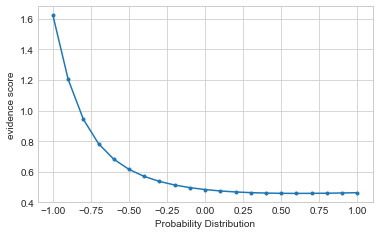

In [160]:
import matplotlib.pyplot as plt
from math import log
plt.style.use('seaborn-whitegrid')
# calculate cross-entropy
def cross_entropy(p, q, ets=1e-15):
	return -sum([p[i]*log(q[i]+ets) for i in range(len(p))])
 
labels =  np.array([[0., 0., 0., 0., 0., 0., 0. ,0. ,1., 0.]])
outputs = np.array([[-0.867575228, -1.408539593, -5.3238, -4.99858856, -4.85228109,
                     -6.52761173, -6.87370205, -6.45510149, 0.890240133 ,-2.260957]])

values = [-1.0, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0.0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1.0]
prediction = range(0,100,1)
probs = []
for j,i in enumerate(values):
    x = outputs
    x = [np.repeat(i,10)]
    x[0][8] = prediction[j]
    print(x)
    # probs.append(tf.reduce_sum(softplus_evidence(x)))
    probs.append(tf.keras.losses.categorical_crossentropy(labels,softplus_evidence(x)))

plt.plot(values, probs, marker='.')
plt.subplots_adjust(bottom=0.2)
plt.xlabel('Probability Distribution')
plt.ylabel('evidence score')
plt.show()



tf.Tensor(
[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7
 0.8 0.9 1. ], shape=(21,), dtype=float32)


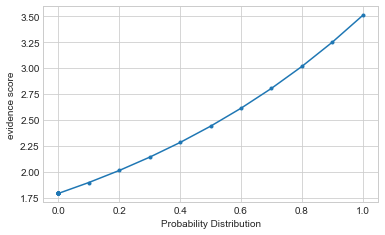

In [49]:
labels =  np.array([[0., 0., 0., 0., 0., 0., 0. ,0. ,1., 0.]])
outputs = np.array([[-0.867575228, -1.408539593, -5.3238, -4.99858856, -4.85228109,
                     -6.52761173, -6.87370205, -6.45510149, 0.890240133 ,-2.260957]])

values = [-1.0, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]
values = tf.keras.activations.relu(values)
print(values)
probs = []
for i in values:
    x = outputs
    x[0][8] = i
    probs.append(tf.reduce_sum(tf.exp(x)))

plt.plot(values, probs, marker='.')
plt.subplots_adjust(bottom=0.2)
plt.xlabel('Probability Distribution')
plt.ylabel('evidence score')
plt.show()


In [9]:
print(softplus_evidence(outputs))
print(tf.keras.activations.softsign(outputs))

tf.Tensor(
[[3.50634790e-01 2.18733917e-01 4.86235611e-03 6.72480167e-03
  7.78019630e-03 1.46142611e-03 1.03410481e-03 1.57124463e-03
  1.23422490e+00 9.91669774e-02]], shape=(1, 10), dtype=float64)
tf.Tensor(
[[-0.46454634 -0.58481065 -0.84186723 -0.83329412 -0.82912646 -0.86715574
  -0.87299494 -0.86586366  0.47096669 -0.69334156]], shape=(1, 10), dtype=float64)


In [5]:
import tensorflow as tf
import numpy as np

def inv_softmax(x, C):
   return tf.math.log(x,10) + tf.cast(C,tf.double)

labels =  np.array([[0., 0., 0., 0., 0., 0., 0. ,0. ,1., 0.]])
outputs = np.array([[-0.867575228, -1.408539593, -5.3238, -4.99858856, -4.85228109,
                     -6.52761173, -6.87370205, -6.45510149, 0.890240133 ,-2.260957]])
y = tf.nn.softmax(outputs)
print(y)
print(tf.reduce_sum(y))
# print(tf.keras.losses.categorical_crossentropy(labels,tf.cast(tf.nn.softmax(y),tf.float32),True))
z = inv_softmax(y,-1)
print(z)
# print(tf.keras.losses.categorical_crossentropy(labels,tf.cast(tf.nn.softmax(z),tf.float32),True))


tf.Tensor(
[[1.30104402e-01 7.57450319e-02 1.51000423e-03 2.09033406e-03
  2.41967046e-03 4.53074240e-04 3.20526731e-04 4.87147152e-04
  7.54573419e-01 3.22963897e-02]], shape=(1, 10), dtype=float64)
tf.Tensor(1.0, shape=(), dtype=float64)
tf.Tensor([2.2162142], shape=(1,), dtype=float32)
tf.Tensor(
[[-3.03941806 -3.58038242 -7.49564283 -7.17043139 -7.02412392 -8.69945456
  -9.04554488 -8.62694432 -1.2816027  -4.43279983]], shape=(1, 10), dtype=float64)


In [6]:

labels =  np.array([[0., 0., 0., 0., 0., 0., 0. ,0. ,1., 0.]])
# outputs = np.array([[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]])
outputs = np.array([[3,3,4,0,1,3,3,3,3,3]])


# # outputs = np.array([[-6,-3,3,-4,-6,-3,-3,-3,-3,-3]])
# print("mse", mse_loss_global(labels,outputs))
# print("evidence",tf.reduce_sum(relu_evidence(outputs)))

# print("keras_mse",tf.keras.losses.mean_squared_error(labels,relu_evidence(outputs)))
# print("keras_mae",tf.keras.losses.mean_absolute_error(labels,(outputs)))
# print("keras_crossE",tf.keras.losses.categorical_crossentropy(labels,tf.cast(outputs,tf.float32),True))
# print("softmax", tf.nn.softmax(tf.cast(outputs,tf.float32)),"label:",tf.argmax(outputs,1))


outputs = np.array([[-0.867575228, -1.408539593, -5.3238, -4.99858856, -4.85228109,
                     -6.52761173, -6.87370205, -6.45510149, 0.890240133 ,-2.260957]])
# outputs = np.array([[1.2,0,1.1,1,0,0,0,0,0,0]])
outputs = tf.cast(outputs,tf.float32)
print("mse", mse_loss_global(labels,outputs))
print("KL",KL(softplus_evidence(outputs)+1))
# print("KL2",KL((softplus_evidence(outputs))+1)*.1)
print("keras KL",tf.keras.losses.kl_divergence(labels,outputs))


print("evidence",tf.reduce_sum(softplus_evidence(outputs)))

print("keras_mse",tf.keras.losses.mean_squared_error(labels,softplus_evidence(outputs)+1))
# print("keras_mae",tf.keras.losses.mean_absolute_error(labels,(outputs)))
print("keras_crossE",tf.keras.losses.categorical_crossentropy(labels,tf.cast(tf.nn.softmax(outputs),tf.float32),True))
print("new total: ",tf.keras.losses.categorical_crossentropy(labels,tf.cast(tf.nn.softmax(outputs),tf.float32),True)+ mse_loss_global(labels,outputs))

# print("keras_crossE",tf.keras.losses.categorical_crossentropy(labels,tf.cast(outputs,tf.float32),True))
print("softmax", tf.nn.softmax(tf.cast(outputs,tf.float32)), "label:",tf.argmax(outputs,1))


global Loss
tf.Tensor(
[[0.3506348  0.2187339  0.00486231 0.00672483 0.00778019 0.00146139
  0.00103414 0.0015713  0.         0.09916699]], shape=(1, 10), dtype=float32)
alp tf.Tensor(
[[1.3506348 1.2187339 1.0048623 1.0067248 1.0077802 1.0014614 1.0010341
  1.0015713 1.        1.099167 ]], shape=(1, 10), dtype=float32)
C tf.Tensor([[0.0915556]], shape=(1, 1), dtype=float32)
mse tf.Tensor([[0.0915556]], shape=(1, 1), dtype=float32)
KL tf.Tensor([[0.5232086]], shape=(1, 1), dtype=float32)
keras KL tf.Tensor([0.11626406], shape=(1,), dtype=float32)
evidence tf.Tensor(1.9261947, shape=(), dtype=float32)
keras_mse tf.Tensor([1.2088009], shape=(1,), dtype=float32)
keras_crossE tf.Tensor([1.677675], shape=(1,), dtype=float32)
global Loss
tf.Tensor(
[[0.3506348  0.2187339  0.00486231 0.00672483 0.00778019 0.00146139
  0.00103414 0.0015713  0.         0.09916699]], shape=(1, 10), dtype=float32)
alp tf.Tensor(
[[1.3506348 1.2187339 1.0048623 1.0067248 1.0077802 1.0014614 1.0010341
  1.0015713 1

In [4]:
import numpy as np
labels =  np.array([[0., 0., 0., 0., 0., 0., 0. ,0. ,1., 0.]])


outputs = np.array([[-0.867575228, 0.408539593, -5.3238, -4.99858856, -4.85228109,
                     -6.52761173, -6.87370205, -6.45510149, 0.890240133 ,-2.260957]])
# outputs = np.array([[1.2,0,1.1,1,0,0,0,0,0,0]])
outputs = tf.cast(tf.keras.activations.sigmoid(outputs),tf.float32)
print(outputs)
outputs = tf.cast(tf.keras.activations.hard_sigmoid(outputs),tf.float32)
print(outputs)
# print("mse", mse_loss_global(labels,outputs))
# print("KL",KL(softplus_evidence(outputs))+1)
# print("KL2",KL((outputs))*.1)
print("keras KL",tf.keras.losses.kl_divergence(labels,outputs))


# print("evidence",tf.reduce_sum(softplus_evidence(outputs)))

# print("keras_mse",tf.keras.losses.mean_squared_error(labels,softplus_evidence(outputs)+1))
# print("keras_mae",tf.keras.losses.mean_absolute_error(labels,(outputs)))
print("keras_crossE",tf.keras.losses.categorical_crossentropy(labels,tf.cast(outputs,tf.float32),True))
print("softmax", tf.nn.softmax(tf.cast(outputs,tf.float32)), "label:",tf.argmax(outputs,1))


tf.Tensor(
[[0.2957591  0.60073763 0.00485055 0.00670224 0.00775001 0.00146036
  0.00103357 0.00157001 0.70893973 0.09440852]], shape=(1, 10), dtype=float32)
tf.Tensor(
[[0.5591518  0.6201475  0.5009701  0.50134045 0.50155    0.50029206
  0.5002067  0.500314   0.64178795 0.5188817 ]], shape=(1, 10), dtype=float32)
keras KL tf.Tensor([0.44348344], shape=(1,), dtype=float32)
keras_crossE tf.Tensor([2.196615], shape=(1,), dtype=float32)
softmax tf.Tensor(
[[0.10236084 0.10879877 0.09657526 0.09661103 0.09663128 0.0965098
  0.09650156 0.09651191 0.11117887 0.09832066]], shape=(1, 10), dtype=float32) label: tf.Tensor([8], shape=(1,), dtype=int64)


In [19]:
import numpy as np
x = np.array([.01,1,6])
y = np.array([0,0,1])
print(tf.keras.losses.mean_squared_error(y,x))

tf.Tensor(8.6667, shape=(), dtype=float64)


In [20]:
out = y - x
print(out)
out = tf.reduce_mean(out*out)
out

[-0.01 -1.   -5.  ]


<tf.Tensor: shape=(), dtype=float64, numpy=8.6667>

In [44]:
tf.exp(tf.clip_by_value(-50.,-10,10))

<tf.Tensor: shape=(), dtype=float32, numpy=4.539993e-05>